In [1]:
import io
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU
from tensorflow.keras import backend
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/gdrive/')

data_path='/content/gdrive/Shareddrives/CMPE297_49_project/dataset/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import kde

In [4]:
call_df = pd.read_csv(data_path+'final_call.csv')
call_df = call_df[['UnderlyingPrice','Strike','Bid','Ask','sigma_5','date_diff','treasury_rate']]
call_df=call_df.dropna()

In [5]:
put_df = pd.read_csv(data_path+'final_put.csv')
put_df = put_df[['UnderlyingPrice','Strike','Bid','Ask','sigma_21','date_diff','treasury_rate']]
put_df=put_df.dropna()

In [6]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(call_df.drop(['Bid', 'Ask'], axis=1),
                                                                        call_df[['Bid', 'Ask']],
                                                                        test_size=0.01, random_state=42)
put_X_train, put_X_test, put_y_train, put_y_test = train_test_split(put_df.drop(['Bid', 'Ask'], axis=1),
                                                                    put_df[['Bid', 'Ask']],
                                                                    test_size=0.01, random_state=42)

In [7]:
from keras.models import load_model
output_path= '/content/gdrive/Shareddrives/CMPE297_49_project/models/'
call = load_model(output_path+'model3_call_sigma5_all_1024_4000.h5')
put = load_model(output_path+'model3_put_all_1024_4000.h5')

In [8]:
call_y_pred = call.predict(call_X_test)
put_y_pred = put.predict(put_X_test)

In [9]:
def error_metrics(actual, predicted):
    diff = actual - predicted
    mse = np.mean(np.square(diff))
    rel = diff / actual
    #bias = 100 * np.median(rel)
    #aape = 100 * np.mean(np.abs(rel))
    #mape = 100 * np.median(np.abs(rel))
    #pe5 = 100 * sum(np.abs(rel) < 0.05) / rel.shape[0]
    #pe10 = 100 * sum(np.abs(rel) < 0.10) / rel.shape[0]
    #pe20 = 100 * sum(np.abs(rel) < 0.20) / rel.shape[0]
    return mse

In [10]:
call_errors = error_metrics(np.mean(call_y_test, axis=1), np.mean(call_y_pred, axis=1))
put_errors = error_metrics(np.mean(put_y_test, axis=1), np.mean(put_y_pred, axis=1))

In [11]:
def matrix(actual, predicted, q):
    rel = (actual - predicted) / actual
    def segregate(x, q):
        up = x > q
        low = x < -q
        mid = ~(up | low)
        return (up, mid, low)
    bid = rel.iloc[:,0]
    ask = rel.iloc[:,1]
    x = segregate(bid, q)
    y = segregate(ask, q)
    return np.array([[sum(x[i] & y[j]) for i in range(3)] for j in range(3)]) / rel.shape[0]

In [12]:
matrix(call_y_test, call_y_pred, 0.01)


array([[0.17802324, 0.11562186, 0.10672787],
       [0.04289198, 0.07990245, 0.03643667],
       [0.18046191, 0.08148042, 0.17845359]])

In [13]:
matrix(put_y_test, put_y_pred, 0.01)


array([[0.13728388, 0.06723807, 0.08378898],
       [0.02127974, 0.01758534, 0.02940742],
       [0.17674006, 0.15974583, 0.30693069]])

In [14]:
matrix(put_y_test, put_y_pred, 0.05)


array([[0.09915768, 0.07551352, 0.04935717],
       [0.0424117 , 0.16861238, 0.03916063],
       [0.09073445, 0.19728092, 0.23777154]])

In [15]:
matrix(call_y_test, call_y_pred, 0.05)


array([[0.09625592, 0.11332664, 0.04504375],
       [0.05192942, 0.35088223, 0.04877349],
       [0.08492325, 0.09539521, 0.11347009]])

In [16]:
def error_scatter(actual, predicted):
    temp = 100 * (actual - predicted) / actual
    plt.scatter(temp.iloc[:,0], temp.iloc[:,1], s=1)
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    plt.xlabel('Bid Error %')
    plt.ylabel('Ask Error %')

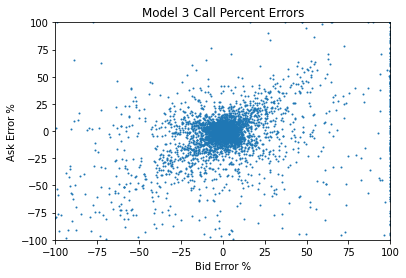

In [17]:
error_scatter(call_y_test, call_y_pred)
plt.title('Model 3 Call Percent Errors')
plt.savefig('model3-call-scatter.png')

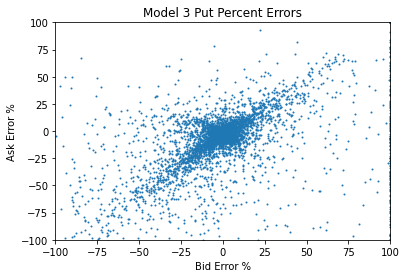

In [18]:
error_scatter(put_y_test, put_y_pred)
plt.title('Model 3 Put Percent Errors')
plt.savefig('model_3-put-scatter.png')

In [19]:
def kde_scatter(actual, predicted):
    rel = 100 * (actual - predicted) / actual
    rel = rel.replace([np.inf, -np.inf], np.nan)
    rel = rel.dropna()
    temp = rel[np.linalg.norm(rel, ord=np.inf, axis=1) < 100]
    k = kde.gaussian_kde(temp.T)
    plt.scatter(temp.iloc[:,0], temp.iloc[:,1], c=k(temp.T), s=1)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.xlabel('Bid Error %')
    plt.ylabel('Ask Error %')

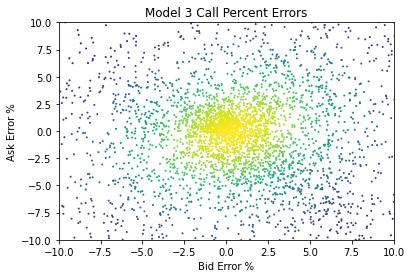

In [20]:
kde_scatter(call_y_test, call_y_pred)
plt.title('Model 3 Call Percent Errors')
plt.savefig('model3-call-kde.png')

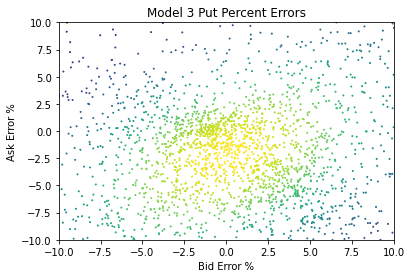

In [21]:

kde_scatter(put_y_test, put_y_pred)
plt.title('Model 3 Put Percent Errors')
plt.savefig('model3-put-kde.png')

In [22]:

call_train_pred = call.predict(call_X_train)
put_train_pred = put.predict(put_X_train)

In [24]:
#call_errors.insert(0, np.mean(np.square(np.diff(call_y_train, axis=1) - np.diff(call_train_pred, axis=1))))

In [ ]:
put_errors.insert(0, np.mean(np.square(np.diff(put_y_train, axis=1) - np.diff(put_train_pred, axis=1))))

In [ ]:
for line in (call_errors, put_errors):
    print('& {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\'.format(*line))
